**ICS5110 Applied Machine Learning**

**Machine Learning Approaches for News Analysis**  

**Group 9. Michelle Desira, SVM Implementation**

In [19]:
#initalised libraries
import pandas as pd
import numpy as np
import re
import regex
import spacy
import openmeteo_requests
import requests_cache
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from retry_requests import retry
import sklearn.metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

In [2]:
# Load Google Drive to access files
from google.colab import drive
drive.mount("/content/drive")

# Define the path to the project folder in Google Drive
path = "/content/drive/MyDrive/ICS5110_applied_ml_assignment_Jan2026-main"
%cd "{path}"

# Load the two CSV files containing news articles and police press releases
local_news_articles = pd.read_csv("local_news_articles.csv")
police_press_releases = pd.read_csv("police_press_releases.csv")

# Add a 'source' column to each DataFrame to identify the origin of the data
local_news_articles['source'] = 'news_article'
police_press_releases['source'] = 'police_report'

# Concatenate relevant columns from both DataFrames into a single combined DataFrame
source = pd.concat([police_press_releases['source'], local_news_articles['source']], axis=0)
title = pd.concat([police_press_releases['title'], local_news_articles['title']], axis=0)
published_date = pd.concat([police_press_releases['date_published'], local_news_articles['publish_date']], axis=0)
content_details = pd.concat([police_press_releases['content'], local_news_articles['content']], axis=0)

# Create a new DataFrame from the concatenated series
csv_data = {'source': source, 'published_date': published_date, 'title': title,'content': content_details}
combined_traffic_data = pd.DataFrame(csv_data).reset_index(drop=True)

# Display the head of the combined DataFrame (commented out)
#display(combined_traffic_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ICS5110_applied_ml_assignment_Jan2026-main


In [3]:
# Initialise new columns in the DataFrame with missing values (pd.NA)
combined_traffic_data["hospital flag"] = pd.NA
combined_traffic_data["date of incident"] = pd.NA
combined_traffic_data["weekday of incident"] = pd.NA
combined_traffic_data["time of incident"] = pd.NA

# Change the 'published_date' column to datetime objects
# 'mixed' format infers the date format, 'dayfirst=True' helps with ambiguity
combined_traffic_data["published_date"] = pd.to_datetime(combined_traffic_data["published_date"], format='mixed', dayfirst=True)

In [4]:
# Create a 'hospital flag' column
# This flag is True if the content contains mentions of 'mater dei' or 'gozo general' (case-insensitive)
# 'na=False' ensures that NaN values are treated as False, preventing errors.
combined_traffic_data["hospital flag"] = combined_traffic_data["content"].str.contains(r"mater dei|gozo general", case=False, na=False)

Extraction of Date of Incident

In [5]:
# Intialise a dictionary with the days of the week, mapping names to numbers (Monday=0, Sunday=6)
weekday_map = { "monday": 0, "tuesday": 1, "wednesday": 2,"thursday": 3, "friday": 4, "saturday": 5, "sunday": 6}
# Create a reverse mapping from number to capitalized weekday name
weekday_names = {v: k.capitalize() for k, v in weekday_map.items()}

# Create a regex pattern to find any mention of a weekday in the content (case-insensitive)
pattern_weekday = re.compile(r"\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b",re.IGNORECASE)

# Incident Date Extraction
# Rule 1: Extracting incident date based on mentions of "Today", "This Morning", "Yesterday", "Last Night" in the content

# Create regex rules to find mentions of "Today" or "This morning"
is_today = combined_traffic_data["content"].str.contains(r"\b(?:today|this morning)\b", case=False, na=False)

# Create regex rules to find mentions of "Yesterday" or "Last Night"
is_yesterday = combined_traffic_data["content"].str.contains(r"\b(?:yesterday|last night)\b", case=False, na=False)

# Apply regex rules to content to create masks for filling 'date of incident'
mask_today_fill = is_today & combined_traffic_data["date of incident"].isna()
mask_yest_fill = is_yesterday & combined_traffic_data["date of incident"].isna()

# If a match for "Today" or "This Morning" is found, set 'date of incident' to 'published_date'
combined_traffic_data.loc[mask_today_fill, "date of incident"] = (combined_traffic_data.loc[mask_today_fill, "published_date"])

# If a match for "Yesterday" or "Last Night" is found, set 'date of incident' to 'published_date - 1 day'
combined_traffic_data.loc[mask_yest_fill, "date of incident"] = (combined_traffic_data.loc[mask_yest_fill, "published_date"] - pd.Timedelta(days=1))

# Rule 2: Determine Weekday of Incident from Date of Incident

# Convert 'date of incident' to datetime objects for weekday extraction, coercing errors
dates_dt = pd.to_datetime(combined_traffic_data["date of incident"], errors="coerce")
# Create a mask for entries where 'weekday of incident' is blank but 'date of incident' is available
mask_infer_weekday = (combined_traffic_data["weekday of incident"].isna() & dates_dt.notna())

# Fill 'weekday of incident' using the extracted weekday from 'date of incident' and the mapping
combined_traffic_data.loc[mask_infer_weekday, "weekday of incident"] = (dates_dt[mask_infer_weekday].dt.weekday.map(weekday_names))

# Rule 3: Extract the weekday from content only when BOTH 'date of incident' + 'weekday of incident' are blank
# Apply regex rule to find mention of a weekday in entries where no date of incident was identified
combined_traffic_data["weekday_mentioned"] = (combined_traffic_data["content"].str.extract(pattern_weekday, expand=False).str.lower())

# Create a mask for entries where both date and weekday of incident are missing, but a weekday is mentioned in content
mask_fill_weekday_from_content = (combined_traffic_data["date of incident"].isna() & combined_traffic_data["weekday of incident"].isna() & combined_traffic_data["weekday_mentioned"].notna())
# Fill 'weekday of incident' from the mentioned weekday in content, capitalizing it
combined_traffic_data.loc[mask_fill_weekday_from_content, "weekday of incident"] = (combined_traffic_data.loc[mask_fill_weekday_from_content, "weekday_mentioned"].str.capitalize())

# Rule 4: If 'date of incident' is blank but a 'weekday of incident' is identified in rule 3, infer date

# Get the weekday number of each respective published date from the dictionary
published_wd = combined_traffic_data["published_date"].dt.weekday

# Get the weekday number from the extracted weekday mentioned in content
mentioned_wd_num = combined_traffic_data["weekday of incident"].astype(str).str.lower().map(weekday_map)

# Calculate the difference in weekday numbers to determine how many days back the incident occurred
days_back = (published_wd - mentioned_wd_num) % 7

# Create a mask for entries where 'date of incident' is still blank but a mentioned weekday number is available
mask_fill_date_from_weekday = (combined_traffic_data["date of incident"].isna()& mentioned_wd_num.notna())

# Update blank 'date of incident' by shifting from 'published_date' based on 'days_back'
combined_traffic_data.loc[mask_fill_date_from_weekday, "date of incident"] = (combined_traffic_data.loc[mask_fill_date_from_weekday, "published_date"]- pd.to_timedelta(days_back[mask_fill_date_from_weekday], unit="D"))

# Rule 5: For Police Reports: if 'date of incident' is still blank, set it to 'published_date'
# Create a mask to determine which entries are police reports and have no incident date identified yet
mask_police_fallback_date = ((combined_traffic_data["source"].astype(str).str.lower() == "police_report") & combined_traffic_data["date of incident"].isna())

# Apply mask and set 'date of incident' = 'published_date' for these entries
combined_traffic_data.loc[mask_police_fallback_date, "date of incident"] = (combined_traffic_data.loc[mask_police_fallback_date, "published_date"])

# Re-run rule 2 to update 'weekday of incident' for newly extracted 'date of incident' values
# Convert 'date of incident' to date format (without time) and then to datetime for consistency
combined_traffic_data["date of incident"] = pd.to_datetime(combined_traffic_data["date of incident"], errors="coerce").dt.date
dates_dt = pd.to_datetime(combined_traffic_data["date of incident"], errors="coerce")
mask_infer_weekday = (combined_traffic_data["weekday of incident"].isna() & dates_dt.notna())
combined_traffic_data.loc[mask_infer_weekday, "weekday of incident"] = (dates_dt[mask_infer_weekday].dt.weekday.map(weekday_names))

# Drop the temporary 'weekday_mentioned' column
combined_traffic_data = combined_traffic_data.drop(columns=["weekday_mentioned"])
#combined_traffic_data.info()
#combined_traffic_data.head()

Extraction of Time of Incident

In [6]:
# Extracting the time of accident in "0930hrs" format

# Creating and applying regex pattern for time extraction (mainly for police reports) in HHMM format
pattern_time = re.compile(r"([0-9:.]+)\s*hrs\b", re.IGNORECASE)
combined_traffic_data["time of incident"] = combined_traffic_data["content"].str.extract(pattern_time, expand=False)

# Handle textual time reference: 'noon' or 'midday' are set to "1200"
combined_traffic_data.loc[combined_traffic_data["content"].str.contains(r"\bnoon|midday\b", case=False, na=False), "time of incident"] = "1200"

# Creating regex pattern to match times like 4pm, 4 pm, 4.45pm, 4:45 p.m., 04:45 a.m., etc.
# It will ignore any times that follow the word 'updated' (safeguard for news articles with updates)
pattern_time_ampm = re.compile(r"(?i)\b(?:updated\s+)?(?P<time>\d{1,2}(?:[.:]\d{2})?\s*(?:a\.?m\.?|p\.?m\.?|am|pm))\b")

# Defining method to apply regex pattern across content and ignore article update times
def extract_first_non_updated_time(text: str):
    if not isinstance(text, str):
        return pd.NA

    # Find all candidate matches of the time pattern
    matches = list(pattern_time_ampm.finditer(text))
    if not matches:
        return pd.NA

    # Iterate through matches and keep only those NOT preceded by "updated "
    for m in matches:
        time_str = m.group("time")

        # Look at the text preceding the time string to check for "updated "
        start = m.start("time")
        prefix = text[max(0, start - 10):start].lower()

        # If the prefix ends with "updated " (case-insensitive), skip this match
        if re.search(r"updated\s*$", prefix, flags=re.IGNORECASE):
            continue

        return time_str.strip()

    return pd.NA

# Applying the regex pattern to extract time in AM/PM format
combined_traffic_data["time_ampm"] = combined_traffic_data["content"].apply(extract_first_non_updated_time)

# Defining method to normalise extracted AM/PM times to HHMM format
def normalise_ampm_to_hhmm(t):
    if not isinstance(t, str):
        return pd.NA

    t = t.lower().strip()

    # Match times like 4pm, 4.45pm, 4:45 p.m., 04:45am
    m = re.match(r"(\d{1,2})(?:[.:](\d{2}))?\s*(a\.?m\.?|p\.?m\.?)", t)
    if not m:
        return pd.NA

    hour = int(m.group(1))
    minute = int(m.group(2)) if m.group(2) else 0
    period = m.group(3)

    if "p" in period and hour != 12: # Convert PM hours (except 12 PM) to 24-hour format
        hour += 12
    if "a" in period and hour == 12: # Convert 12 AM to 00 (midnight)
        hour = 0

    return f"{hour:02d}{minute:02d}" # Format as HHMM (e.g., 0930, 1400)

# Maps times extracted and formatted to the 'time of incident' column
mask_fill_time = (combined_traffic_data["time of incident"].isna()& combined_traffic_data["time_ampm"].notna())
combined_traffic_data.loc[mask_fill_time, "time of incident"] = (combined_traffic_data.loc[mask_fill_time, "time_ampm"].apply(normalise_ampm_to_hhmm))

def normalise_any_time_to_hhmm(t):
    if t is None or pd.isna(t):
        return pd.NA
    t = str(t).strip().lower()

    # If already 3-4 digits like 700 / 0930 / 1545, zfill to ensure 4 digits
    digits = re.sub(r"[^\d]", "", t)
    if digits.isdigit():
        if len(digits) in (3, 4):
            return digits.zfill(4)

    # Try am/pm format again if something slipped through initial regex
    out = normalise_ampm_to_hhmm(t)
    return out if out is not pd.NA else pd.NA

# Apply the final normalization to the 'time of incident' column
combined_traffic_data["time of incident"] = combined_traffic_data["time of incident"].apply(normalise_any_time_to_hhmm)

# Drop the temporary 'time_ampm' column
combined_traffic_data = combined_traffic_data.drop(columns=["time_ampm"])

# Print info for accident-related news articles (commented out)
#combined_traffic_data[(combined_traffic_data["accident_flag"] == 1) & (combined_traffic_data["source"] == "news_article")].info()
#combined_traffic_data.head()

Importing cities dataset


In [7]:
# Importing dataset with cities
world_cities_dataset = pd.read_csv("worldcities.csv")
# world_cities_dataset.info()

# Keeping relevant columns
df_world_cities_reduced = world_cities_dataset.drop(columns = ["iso2", "iso3", "admin_name", "capital"])
# df_world_cities_reduced.info()

# Keeping only cities in Malta
df_malta_cities = df_world_cities_reduced[df_world_cities_reduced["country"] == "Malta"]
# df_malta_cities.info()
# df_malta_cities.head(50)

Extracting City Names from Text

In [8]:
def sort_cities(cities_df, column_name):
    """
    Return a list of city names sorted from longest to shortest.
    Sorting by length avoids partial string matches.
    """
    if column_name not in cities_df.columns:
        print(f"{column_name} not found in dataset.")
        return []

    return sorted(
        cities_df[column_name].dropna().tolist(),
        key=len,
        reverse=True
    )


def search_for_city(text, city_list):
    """
    Search for a city name in text.
    Prioritises high-confidence location patterns and filters out
    residence-related mentions.
    """
    if pd.isna(text):
        return None

    text = text.lower().replace("’", "'").replace("`", "'")

    location_indicators = [
        r'\bon ', r'\bin ', r'\bat ', r'\bnear ',
        r'\balong ', r'\bbypass', r'\btriq ',
        r'\bdawret ', r'\broad ', r'\bstreet '
    ]

    # First pass: indicator-based matching
    for city in city_list:
        city_lower = city.lower()

        for indicator in location_indicators:
            pattern = (
                indicator +
                r'(?:\w+\s+){0,5}?' +
                r'\b' + re.escape(city_lower) + r'\b'
            )

            for match in re.finditer(pattern, text):
                before = text[max(0, match.start() - 20):match.start()]
                after = text[match.end():match.end() + 10]

                if re.search(r'lives|resid|from', before):
                    continue

                if re.search(r'^\s*(road|street|bypass|avenue)', after):
                    continue

                return city

    # Second pass: broad city-only matching
    for city in city_list:
        city_lower = city.lower()
        pattern = r'\b' + re.escape(city_lower) + r'\b'

        for match in re.finditer(pattern, text):
            before = text[max(0, match.start() - 20):match.start()]
            after = text[match.end():match.end() + 10]

            if re.search(r'lives|resid|from', before):
                continue

            if re.search(r'^\s*(road|street|bypass|avenue)', after):
                continue

            return city

    return None


def get_city_info(cities_df, city_name, search_column):
    """
    Retrieve city metadata (coordinates and population)
    for a matched city.
    """
    city_row = cities_df[cities_df[search_column] == city_name].iloc[0]

    return {
        "city_id": city_row["id"],
        "city": city_row["city"],
        "latitude": city_row["lat"],
        "longitude": city_row["lng"],
        "population": city_row["population"]
    }


def extract_city_and_coordinates(text_df, cities_df, testing = False):
    """
    Extract city names from article text and enrich the dataset
    with geographic information.
    """
    city_main = sort_cities(cities_df, "city")
    city_other = sort_cities(cities_df, "city_other")

    print(f"Searching through {len(city_main)} Maltese cities.")

    results = []

    for idx, row in text_df.iterrows():
        title = row["title"]
        content = row["content"]

        result = row.to_dict()
        found_city = None
        matched_column = None
        found_in = None

        for source, text in [("title", title), ("content", content)]:
            found_city = search_for_city(text, city_main)
            if found_city:
                matched_column = "city"
                found_in = source
                break

            found_city = search_for_city(text, city_other)
            if found_city:
                matched_column = "city_other"
                found_in = source
                break

        if found_city:
            city_data = get_city_info(cities_df, found_city, matched_column)
            result.update({
                **city_data,
                "found_in": found_in
            })
        else:
          if testing:
            print(f"No location found for row {idx}: '{row['title']}'")
            result.update({
                "city": None,
                "city_id": None,
                "latitude": None,
                "longitude": None,
                "population": None,
                "found_in": None
            })

        results.append(result)

    matched_df = pd.DataFrame(results)

    print("\n" + "=" * 80)
    print("EXTRACTION SUMMARY")
    print("=" * 80)
    print(f"Cities found: {matched_df['city'].notna().sum()}")
    print(f"Cities not found: {matched_df['city'].isna().sum()}")
    print(f"Success rate: {matched_df['city'].notna().mean() * 100:.1f}%")
    print("\nTop 10 cities:")
    print(matched_df["city"].value_counts().head(10))

    return matched_df


In [14]:
# Extract city and coordinate information for the combined traffic data
# The 'False' argument for 'testing' means no print statements for unfound locations
combined_with_cities_df = extract_city_and_coordinates(combined_traffic_data, df_malta_cities, False)

# Display results (commented out)
#combined_with_cities_df = combined_with_cities_df.drop(columns=["city_id","found_in"])
#combined_traffic_data.head()
#combined_with_cities_df.head(10)
#combined_with_cities_df.to_excel('combined_with_cities.xlsx', index=False)

Searching through 69 Maltese cities.

EXTRACTION SUMMARY
Cities found: 353
Cities not found: 79
Success rate: 81.7%

Top 10 cities:
city
Marsa               25
Naxxar              21
Saint Paul’s Bay    18
Sliema              16
Birkirkara          14
Valletta            13
Paola               12
Żebbuġ              12
Attard              11
San Ġwann           11
Name: count, dtype: int64


 Importing weather data for time and location of accident.



In [10]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [20]:
# Basis of this code obtained from open-meteo API docs : https://open-meteo.com/en/docs/historical-weather-api
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Historical API endpoint
archive_url = "https://archive-api.open-meteo.com/v1/archive"

# List of chosen weather variables to retrieve from the API
daily_weather_variables = ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "precipitation_sum","precipitation_hours", "rain_sum", "wind_speed_10m_max"]

# Creating a copy of the DataFrame to store weather information
locations_weather_df = combined_with_cities_df.copy()

# Creating a new temporary date string column for the API request format (YYYY-MM-DD)
# Coerce errors will turn invalid dates into NaT (Not a Time), which will become NaN strings
locations_weather_df["date_str"] = pd.to_datetime(locations_weather_df["date of incident"], errors="coerce").dt.strftime("%Y-%m-%d")

# Initializing weather variables columns with None in the DataFrame
for variable in daily_weather_variables:
	locations_weather_df[f"weather_{variable}"] = None

# Initialize 'skipped' counter for rows where API call could not be made
skipped = 0

# Looping through the entries in the DataFrame to fetch weather data
for idx, row in locations_weather_df.iterrows():
	# Skip if coordinates (longitude, latitude) or date are empty
	if pd.isna(row["date_str"]) or pd.isna(row["longitude"]) or pd.isna(row["latitude"]):
		skipped +=1
		continue

	# Extracting weather data according to the given variables using a try-except block
	# This helps avoid total crashes if the API request fails for a specific row.
	try:
		params = {
				 "latitude": row["latitude"],
				 "longitude": row["longitude"],
				 "start_date": row["date_str"],
				 "end_date": row["date_str"],
				 "daily": daily_weather_variables,
				 "timezone": "Europe/Berlin" }

		responses = openmeteo.weather_api(archive_url, params=params)
		daily = responses[0].Daily()

		# Loop for extracting the daily variables from Open-Meteo API response
		# The order of extraction is the same as variables were listed in daily_weather_variables
		for i, var in enumerate(daily_weather_variables):
			values = daily.Variables(i).ValuesAsNumpy()

			# If the request is successful and returns values, add the first value to the DataFrame
			if len(values) >0:
				locations_weather_df.at[idx, f"weather_{var}"] = values[0] # API returns an array, we take the first value.

	except Exception as error:
		print(f" Error in row {idx}: {error}")


# Converting numerical weather codes to descriptive categories.
# Code conversion based on WMO Weather interpretation codes.
def weather_categories(code):
	if pd.isna(code): return None
	code = int(code)
	if code in [0,1]: return "sunny/clear"
	if code in [2,3]: return "cloudy"
	if code in [45,48]: return "foggy"
	if code in [51, 53, 55, 61, 63, 65]: return "rain/drizzle"
	return "other"

# Adding a new column with the derived weather category
locations_weather_df["weather_category"] = locations_weather_df["weather_weather_code"].apply(weather_categories)

# Save to excel (commented out)
#locations_weather_df.to_excel("locations_weather.xlsx")

# Create a final combined DataFrame with city and weather information
combined_cities_weather_df = locations_weather_df.copy()
#combined_cities_weather_df.info()
#combined_cities_weather_df.head()

In [21]:
preprocessed_data = combined_cities_weather_df
# Get a list of column names from the preprocessed_data DataFrame
res1 = list(preprocessed_data.columns)

# Define a function to check if any word from a given dictionary appears in a sentence
def contains_dictionary_word(sentence,dictionary):
    # Convert the sentence to lowercase
    sentence = sentence.lower()
    # Extract all words from the sentence using regex
    words = re.findall(r"\b\w+\b",sentence)
    # Return 1 if any word in the sentence is found in the dictionary, otherwise 0
    return int(any(word in words for word in dictionary))

In [22]:
# Dictionaries of keywords used for flagging different categories in text data
car_dictionary = {"car","privatecar","passenger","saloon","hatchback","estate","sedan","coupe","convertible","cabriolet","suv","crossover","4x4","toyota",
"ford","volkswagen","vw","hyundai","kia","nissan","peugeot","renault","citroen","fiat","skoda","seat","opel","suzuki","mazda","honda","bmw","mercedes","mercedesbenz",
"audi","volvo","mini","alfa","romeo","lancia","smart","dacia","cupra","landrover","range","rover","jeep","tesla","mg","byd","polestar","mitsubishi","chevrolet","lexus","porsche",
"jaguar","car","cars","carmotorcycle","vancar","hitandrun","electric","twocar"} # Keywords related to cars
motorcycle_dictionary = {"motorcycle","motorbike","motorcyclist","biker","rider","powered twowheeler","scooter","moped","quad bike","quadbike","honda","yamaha","kymco","sym",
"piaggio","vespa", "suzuki","kawasaki","bmw","ducati","ktm","benelli","cfmoto","zontes","royal","enfield","husqvarna","aprilia","motoguzzi","moto","guzzi","gilera","scooters",
"scooter","keeway","malaguti","polaris","canam","motorist","motorists","motorcyclists","carmotorcycle","motorcycletruck","vanmotorcycle","escooter"} # Keywords related to motorcycles
heavy_vehicle_dictionary = {"lorry","truck","articulated","lorry","trailer","semitrailer","heavy","hgv","commercial","delivery","panel",
"van","bus","route","coach","public","transport","publictransportvehicle","publictransport","vanmotorcycle","vancar","motorcycletruck"}# Keywords related to heavy vehicles
pedestrian_dictionary = {"pedestrian","onfoot","foot","walker","crossing","pedestrians"} # Keywords related to pedestrians
fatal_dictionary = {"dead", "death","fatal", "died","passed","away","succumbed","fatality","fatalities","life","lost","deceased"} # Keywords related to fatalities
injury_dictionary = {"injured","injuries"} # Keywords related to injuries
hospital_dictionary = {"hospitalised","hospitalized","hospital","admitted","medical", "treatment", "stable"} # Keywords related to hospitalisation
severe_dictionary = {"grievously","injured","seriously","severe","critical","condition","serious","lifethreatening","intensive",
"hurt","death","fatal","serious","injured","seriously","grievously","killed","dies","hospital","hospitalised","suffers","injuries"} # Keywords related to severe outcomes
minor_dictionary = {"minor","slight","light","discharged","superficial", "cuts","bruises"} # Keywords related to minor injuries
accident_dictionary = {"crash","accident","collision","accidents","crashes","collission","impact"} # Keywords related to accidents
bike_dictionary = {"cyclist"} # Keywords related to bicycles/cyclists
male_gender_dictionary = {"man","men","male","him"} # Keywords related to male gender
female_gender_dictionary = {"woman","women","female","her"} # Keywords related to female gender
drug_alcohol_dictionary = {"alcohol","drunk","drug","drugs","arrested","prison"} # Keywords related to drug/alcohol
traffic_dictionary = {"traffic"} # Keywords related to traffic
control_dictionary = {"tree", "pole", "singlevehicle","wall","retaining","building","storefront","barrier","hit","sreike","offroad","skid","slip","lose","lost","roadside"} # Keywords related to loss of control

In [23]:
df = pd.DataFrame()

In [24]:
# Initialise an empty DataFrame to store flags
df = pd.DataFrame()

# Apply the 'contains_dictionary_word' function to the 'title' column of preprocessed_data
# This creates binary (0/1) flag columns based on keyword matches in the title
df["accident_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,accident_dictionary))
df["hospital_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,hospital_dictionary))
df["fatal_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,fatal_dictionary))
df["injury_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,injury_dictionary))
df["severe_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,severe_dictionary))
df["minor_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,minor_dictionary))
df["motorcycle_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,motorcycle_dictionary))
df["bike_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,bike_dictionary))
df["car_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,car_dictionary))
df["gender_M_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,male_gender_dictionary))
df["gender_F_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,female_gender_dictionary))
df["heavy_vehicle_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,heavy_vehicle_dictionary))
df["pedestrian_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,pedestrian_dictionary))
df["illegal_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,drug_alcohol_dictionary))
df["traffic_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,traffic_dictionary))
df["vehicle_count"] = df[['motorcycle_flag', 'bike_flag', 'car_flag', 'heavy_vehicle_flag']].sum(axis=1) # Sum of vehicle flags to get a count
df["control_flag"] = preprocessed_data["title"].apply(lambda s: contains_dictionary_word(s,control_dictionary))

In [25]:
# Create a dictionary from the flag columns in 'df'
data = {'accident_flag': df["accident_flag"],'hospital_flag': df["hospital_flag"],
'fatal_flag': df["fatal_flag"],'injury_flag': df["injury_flag"],'severe_flag': df["severe_flag"],'minor_flag': df["minor_flag"],'motorcycle_flag': df["motorcycle_flag"],
'bike_flag': df["bike_flag"],'car_flag': df["car_flag"],'gender_M_flag': df["gender_M_flag"],'gender_F_flag': df["gender_F_flag"],'heavy_vehicle_flag': df["heavy_vehicle_flag"],
'pedestrian_flag': df["pedestrian_flag"],'illegal_flag': df["illegal_flag"],'traffic_flag': df["traffic_flag"],'control_flag': df["control_flag"]
       ,'vehicle_count': df["vehicle_count"]}
# Create a new DataFrame 'flagged_data' from this dictionary
flagged_data = pd.DataFrame(data)
# Display the flagged_data DataFrame (commented out)
#flagged_data

In [26]:
# Get a list of column names from the 'flagged_data' DataFrame
res2 = list(flagged_data.columns)
# Combine the list of column names from preprocessed_data (res1) and flagged_data (res2)
joinedlist = res1 + res2

# Create a list of DataFrames to concatenate
dfs = [preprocessed_data,flagged_data]

# Concatenate 'preprocessed_data' and 'flagged_data' horizontally
# 'outer' join keeps all rows, 'ignore_index=True' resets the index for the new DataFrame
combined_traffic_data = pd.concat(dfs, axis=1, join='outer', ignore_index=True)
# Assign the combined list of column names to the new DataFrame
combined_traffic_data.columns = joinedlist

# Save to CSV (commented out)
#combined_traffic_data.to_csv('cleaned_data_using_title.csv', index=False)

# Calculate sums of various flag columns for descriptive statistics (using title-based flags)
cars = sum(flagged_data["car_flag"])
motorcycles = sum(flagged_data["motorcycle_flag"])
bike = sum(flagged_data["bike_flag"])
heavy = sum(flagged_data["heavy_vehicle_flag"])
control = sum(flagged_data["control_flag"])

accidents = sum(flagged_data["accident_flag"])
fatal = sum(flagged_data["fatal_flag"])
serious = sum(flagged_data["severe_flag"])
minor = sum(flagged_data["minor_flag"])

In [27]:
#print("From word extraction we managed to conclude that there were;", "\n",
#      "A total of  ", cars, "  car related entries", "\n",   #68
#     "A total of  ", motorcycles, "  motorcycle related entries", "\n",  #109
#      "A total of  ", bike, "  bike related entries","\n",  #8
#      "A total of  ", heavy, "  heavy vehicle related entries", "\n", #29
#      "A total of ", control, " loss of control/object related entries", #31
#      "\n")

In [28]:
#print("We also managed to extract that there were;", "\n",
#     "A total of  ", accidents, "  accidents", "\n", #273
#    "A total of  ", fatal, "  fatalities", "\n", #34
#   "A total of  ", serious, "  serious injuries", "\n", #219
#  "A total of  ", minor, "  minor injuries", "\n") #2

In [29]:
# Initialise an empty DataFrame to store flags
df = pd.DataFrame()

# Apply the 'contains_dictionary_word' function to the 'content' column of preprocessed_data
# This creates binary (0/1) flag columns based on keyword matches in the full content
df["accident_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,accident_dictionary))
df["hospital_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,hospital_dictionary))
df["fatal_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,fatal_dictionary))
df["injury_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,injury_dictionary))
df["severe_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,severe_dictionary))
df["minor_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,minor_dictionary))
df["motorcycle_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,motorcycle_dictionary))
df["bike_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,bike_dictionary))
df["car_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,car_dictionary))
df["gender_M_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,male_gender_dictionary))
df["gender_F_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,female_gender_dictionary))
df["heavy_vehicle_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,heavy_vehicle_dictionary))
df["pedestrian_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,pedestrian_dictionary))
df["illegal_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,drug_alcohol_dictionary))
df["traffic_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,traffic_dictionary))
df["vehicle_count"] = df[['motorcycle_flag', 'bike_flag', 'car_flag', 'heavy_vehicle_flag']].sum(axis=1) # Sum of vehicle flags
df["control_flag"] = preprocessed_data["content"].apply(lambda s: contains_dictionary_word(s,control_dictionary))

In [30]:
# Create a dictionary from the flag columns in 'df'
data = {'accident_flag': df["accident_flag"],'hospital_flag': df["hospital_flag"],
'fatal_flag': df["fatal_flag"],'injury_flag': df["injury_flag"],'severe_flag': df["severe_flag"],'minor_flag': df["minor_flag"],'motorcycle_flag': df["motorcycle_flag"],
'bike_flag': df["bike_flag"],'car_flag': df["car_flag"],'gender_M_flag': df["gender_M_flag"],'gender_F_flag': df["gender_F_flag"],'heavy_vehicle_flag': df["heavy_vehicle_flag"],
'pedestrian_flag': df["pedestrian_flag"],'illegal_flag': df["illegal_flag"],'traffic_flag': df["traffic_flag"],'control_flag': df["control_flag"]
       ,'vehicle_count': df["vehicle_count"]}
# Create a new DataFrame 'flagged_data' from this dictionary
flagged_data = pd.DataFrame(data)
# Display the flagged_data DataFrame (commented out)
#flagged_data

In [31]:
# Create a list of DataFrames to concatenate (preprocessed_data and the newly generated flagged_data)
dfs = [preprocessed_data,flagged_data]

# Concatenate 'preprocessed_data' and 'flagged_data' horizontally
# 'outer' join keeps all rows, 'ignore_index=True' resets the index for the new DataFrame
combined_traffic_data = pd.concat(dfs, axis=1, join='outer', ignore_index=True)
# Assign the combined list of column names (from previous cells) to the new DataFrame
combined_traffic_data.columns = joinedlist

# Save to CSV (commented out)
#combined_traffic_data.to_csv('cleaned_data_using_content.csv', index=False)

# Calculate sums of various flag columns for descriptive statistics (using content-based flags)
cars = sum(flagged_data["car_flag"])
motorcycles = sum(flagged_data["motorcycle_flag"])
bike = sum(flagged_data["bike_flag"])
heavy = sum(flagged_data["heavy_vehicle_flag"])
control = sum(flagged_data["control_flag"])

accidents = sum(flagged_data["accident_flag"])
fatal = sum(flagged_data["fatal_flag"])
serious = sum(flagged_data["severe_flag"])
minor = sum(flagged_data["minor_flag"])

In [32]:
#print("From word extraction we managed to conclude that there were;", "\n",
#      "A total of  ", cars, "  car related entries", "\n", #326
#     "A total of  ", motorcycles, "  motorcycle related entries", "\n", #234
#      "A total of  ", bike, "  bike related entries","\n", #10
#      "A total of  ", heavy, "  heavy vehicle related entries", "\n", #132
#      "A total of ", control, " loss of control/object related entries", #208
#      "\n")

In [33]:
#print("We also managed to extract that there were;", "\n",
#     "A total of  ", accidents, "  accidents", "\n", #375
#     "A total of  ", fatal, "  fatalities", "\n", #188
#     "A total of  ", serious, "  serious injuries", "\n", #375
#     "A total of  ", minor, "  minor injuries", "\n") #49

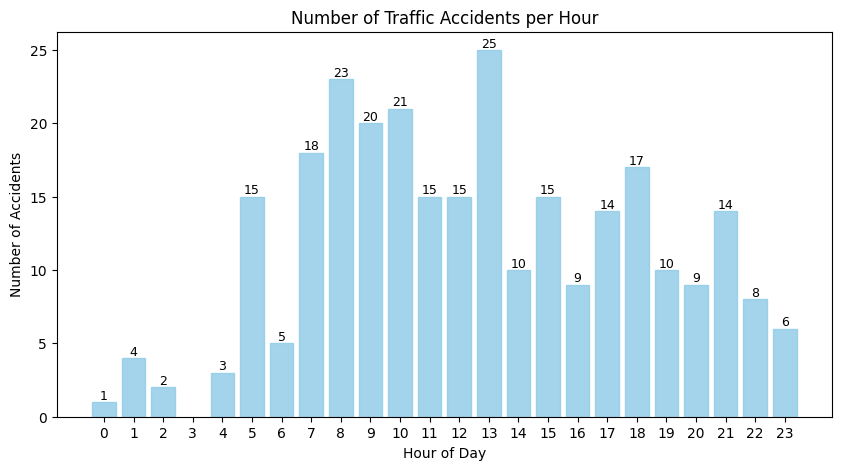

In [34]:
eda_df = combined_traffic_data.reset_index(drop=True).copy()
# Create the boolean mask using .values to avoid potential index alignment issues
# Explicitly select the first 'accident_flag' column in case of duplicates
mask = (eda_df["accident_flag"] == 1).values & (eda_df["time of incident"].notna()).values
eda_df = eda_df.iloc[mask].copy()
eda_df["hour"] = eda_df["time of incident"].astype(str).str[:2].astype(int)
#eda_df[["accident_flag", "time of incident", "hour"]].head()

# Count accidents per hour
hour_counts = eda_df["hour"].value_counts().sort_index()

plt.figure(figsize=(10, 5))

bars = plt.bar(
    hour_counts.index,
    hour_counts.values,
    edgecolor="black",
    alpha=0.8
)

# Light blue colour
for bar in bars:
    bar.set_color("#8ecae6")  # pretty light blue

# Labels
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.title("Number of Traffic Accidents per Hour")
plt.xticks(range(0, 24))

# Print count on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        int(height),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.show()
#eda_df.head()'
#eda_df.info()

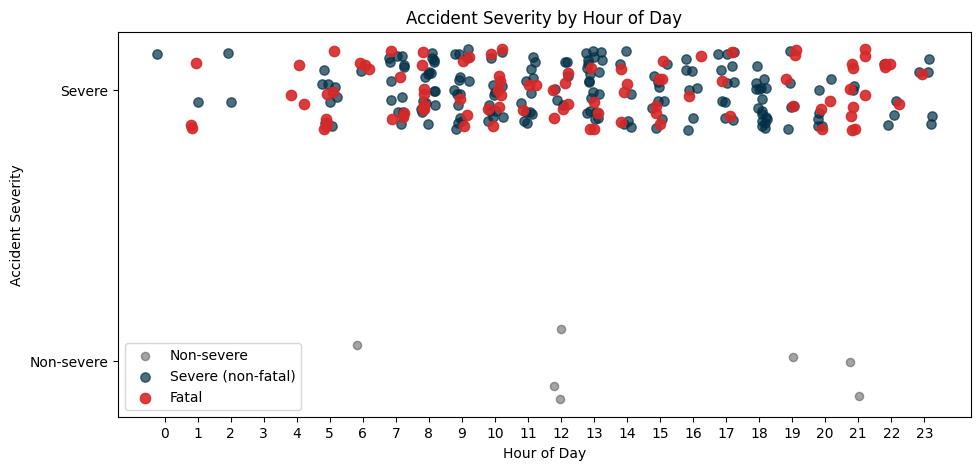

In [35]:
plt.figure(figsize=(11, 5))

# Vertical jitter is added to the 'severe_flag' to visually separate overlapping points
severity_jitter = eda_df["severe_flag"] + np.random.uniform(
    -0.15, 0.15, size=len(eda_df)
)

# Horizontal jitter is added to 'hour' for better visualization of dense points
hour_jitter = eda_df["hour"] + np.random.uniform(
    -0.25, 0.25, size=len(eda_df)
)

# Plotting non-severe accidents
mask_non_severe = eda_df["severe_flag"] == 0
plt.scatter(
    hour_jitter[mask_non_severe],
    severity_jitter[mask_non_severe],
    color="#4a4a4a",   # dark grey
    alpha=0.5,
    s=35,
    label="Non-severe"
)

# Plotting severe but not fatal accidents
mask_severe_not_fatal = (eda_df["severe_flag"] == 1) & (eda_df["fatal_flag"] == 0)
plt.scatter(
    hour_jitter[mask_severe_not_fatal],
    severity_jitter[mask_severe_not_fatal],
    color="#023047",   # dark blue
    alpha=0.7,
    s=45,
    label="Severe (non-fatal)"
)

# Plotting fatal accidents
mask_fatal = (eda_df["severe_flag"] == 1) & (eda_df["fatal_flag"] == 1)
plt.scatter(
    hour_jitter[mask_fatal],
    severity_jitter[mask_fatal],
    color="#d62828",   # red
    alpha=0.9,
    s=55,
    label="Fatal"
)

# Setting y-axis ticks and labels for severity
plt.yticks([0, 1], ["Non-severe", "Severe"])
plt.xlabel("Hour of Day")
plt.ylabel("Accident Severity")
plt.title("Accident Severity by Hour of Day")
plt.xticks(range(0, 24)) # Set x-axis ticks for each hour
plt.legend()
plt.show()

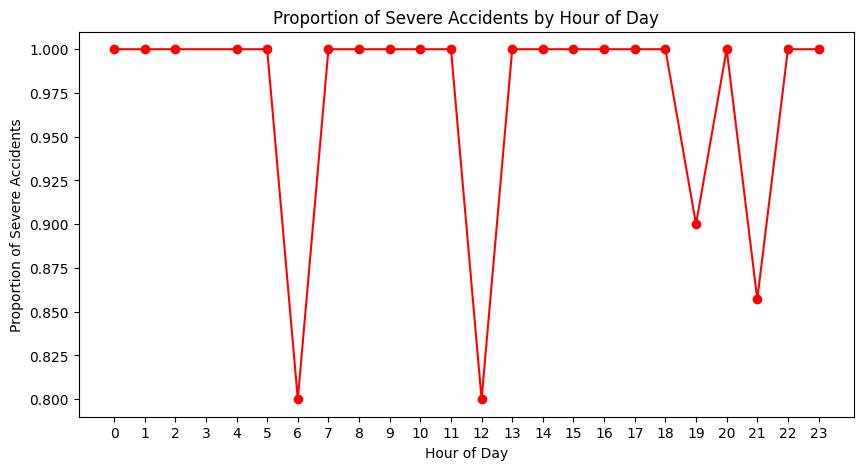

In [36]:
# Calculate the proportion of severe accidents for each hour of the day
severe_by_hour = eda_df.groupby("hour")["severe_flag"].mean()

plt.figure(figsize=(10, 5))
# Plot the proportion of severe accidents by hour
plt.plot(severe_by_hour.index, severe_by_hour.values, marker="o", color="red")
plt.xlabel("Hour of Day")
plt.ylabel("Proportion of Severe Accidents")
plt.title("Proportion of Severe Accidents by Hour of Day")
plt.xticks(range(0, 24)) # Set x-axis ticks for each hour
plt.show()

In [38]:
#eda_df.groupby("hour")["severe_flag"].agg(["count", "mean"])

In [39]:
svm_df = combined_traffic_data.copy()
# Explicitly select the first 'accident_flag' column in case of duplicates
svm_df = svm_df[svm_df["accident_flag"] == 1].copy()

# ---- Hour from time string ----
svm_df["hour"] = pd.to_numeric(
    svm_df["time of incident"].astype(str).str.replace(":", "", regex=False).str[:2],
    errors="coerce"
)

# Create time_bin categories based on hour
svm_df["time_bin"] = pd.cut(
    svm_df["hour"],
    bins=[-1, 5, 11, 17, 23],
    labels=["Night", "Morning", "Afternoon", "Evening"]
)

# ---- Date → month + weekday ----
# Convert 'date of incident' to datetime objects
svm_df["date of incident"] = pd.to_datetime(svm_df["date of incident"], errors="coerce")
# Extract month as an integer
svm_df["month_of_incident"] = svm_df["date of incident"].dt.month
# Fill any missing months with 0 and convert to integer type
svm_df["month_of_incident"] = svm_df["month_of_incident"].fillna(0).astype(int)

# Map weekday names to numerical values
svm_df["weekday of incident"] = svm_df["weekday of incident"].map({
    "Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4,
    "Friday": 5, "Saturday": 6, "Sunday": 7
})

# Fill any missing weekday numbers with 0 and convert to integer type
svm_df["weekday of incident"] = svm_df["weekday of incident"].fillna(0).astype(int);

# ---- Weather category numeric ----
# Map weather category strings to numerical values
svm_df["weather_category"] = svm_df["weather_category"].map({
    "cloudy": 1,
    "rain/drizzle": 2,
    "sunny/clear": 3
})

# Fill any missing weather categories with 0 and convert to integer type
svm_df["weather_category"] = svm_df["weather_category"].fillna(0).astype(int);

# ---- City → regions numeric ----
# Define a mapping from city names to predefined region numbers
city_to_region = {
    "Naxxar": 5, "Marsa": 1, "Saint Paul’s Bay": 5, "Birkirkara": 2,
    "Żebbuġ": 4, "Sliema": 2, "Żejtun": 3, "Attard": 4, "Paola": 1,
    "Żabbar": 1, "Floriana": 1, "San Ġwann": 2, "Mellieħa": 5,
    "Rabat": 4, "Fgura": 1, "Imsida": 2, "Santa Venera": 2, "Luqa": 1,
    "Siġġiewi": 4, "Gżira": 2, "Valletta": 1, "Marsaskala": 3,
    "Pembroke": 2, "Victoria": 6, "Gudja": 3, "Qormi": 2, "Lija": 4,
    "Xewkija": 6, "Birżebbuġa": 3, "Mosta": 5, "Mġarr": 5,
    "Ħamrun": 2, "Żurrieq": 3, "Pietà": 2, "Għajnsielem": 6,
    "Tarxien": 1, "Marsaxlokk": 3, "Għaxaq": 3, "Imtarfa": 4,
    "Iklin": 4, "Qala": 6, "Xagħra": 6, "Swieqi": 2, "Kirkop": 3,
    "Buġibba": 5, "Senglea": 1, "Sannat": 6, "Cospicua": 1,
    "Balzan": 4, "Ta’ Xbiex": 2, "Għarb": 6, "Vittoriosa": 6,
    "Nadur": 6, "Qrendi": 3, "Imqabba": 3
}
# Apply the city-to-region mapping to create a 'regions' column
svm_df["regions"] = svm_df["city"].map(city_to_region)

# Fill any missing regions with 0 and convert to integer type
svm_df["regions"] = svm_df["regions"].fillna(0).astype(int);

# --- Hour: median imputation + missing indicator ---

# Create a binary indicator for missing 'hour' values BEFORE imputation
svm_df["hour_missing"] = svm_df["hour"].isna().astype(int)

# Compute the median hour from the non-missing 'hour' values
hour_median = svm_df["hour"].median()

# Fill missing 'hour' values with the calculated median
svm_df["hour"] = svm_df["hour"].fillna(hour_median);

# Convert 'hour' to integer type for cleaner representation
svm_df["hour"] = svm_df["hour"].round().astype(int);

# ---- Drop columns that are no longer needed for modeling or were transformed/replaced ----
drop_cols = [
    "source", "published_date", "title", "content",
    "latitude", "longitude", "population",
    "date_str",
    "time of incident",          # Raw time string, replaced by 'hour' and 'time_bin'
    "city",                      # Replaced by 'regions'
    "date of incident",          # Replaced by 'month_of_incident' and 'weekday of incident'
    "weather_temperature_2m_max", "weather_temperature_2m_min", # Detailed weather, not used directly
    "weather_temperature_2m_mean", "weather_precipitation_sum",
    "weather_precipitation_hours", "weather_weather_code",
    "weather_rain_sum", "weather_wind_speed_10m_max",
    "minor_flag", "gender_M_flag", "gender_F_flag",
]

svm_df = svm_df.drop(columns=drop_cols, errors="ignore");

# ---- Remove leakage columns if the target is 'severe_flag' ----
# These columns might directly indicate the severity or outcome, leading to data leakage.
LEAKAGE_COLS = ["hospital_flag", "hospital flag", "injury_flag", "fatal_flag"]
svm_df = svm_df.drop(columns=[c for c in LEAKAGE_COLS if c in svm_df.columns], errors="ignore");

# ---- Convert all boolean columns to integer (0 or 1) ----
bool_cols = svm_df.select_dtypes(include="bool").columns
svm_df[bool_cols] = svm_df[bool_cols].astype(int);

#svm_df.head(10)
#svm_df.info();

In [40]:
svm_df = svm_df[svm_df["accident_flag"] == 1].copy()

svm_df["severe_flag"].value_counts()
svm_df["severe_flag"].value_counts(normalize=True)


,proportion
severe_flag,
1,0.933333
0,0.066667


In [41]:
# Define the target column for the SVM model
TARGET_COL = "severe_flag"

# Define lists of categorical and numerical features for different feature sets
# TIME_CAT: Categorical time-related features
TIME_CAT = ["weekday of incident", "month_of_incident"]   # Only if month exists
# TIME_NUM: Numerical time-related features
TIME_NUM = ["hour", "hour_missing"]                       # Numeric time signal

# LOCATION_CAT: Categorical location-related features
LOCATION_CAT = ["regions"]

# VEHICLES: Features related to types of vehicles involved
VEHICLES = ["vehicle_count", "car_flag", "bike_flag", "motorcycle_flag",
            "heavy_vehicle_flag", "pedestrian_flag"]

# CONTEXT: Contextual features
CONTEXT = ["traffic_flag", "illegal_flag", "control_flag"]

# WEATHER_CAT: Categorical weather-related features
WEATHER_CAT = ["weather_category"]

In [42]:
def check_cols(df, cols, name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"Missing in {name}: {missing}")
    else:
        print(f"{name}: OK")

check_cols(svm_df, TIME_CAT, "TIME_CAT")
check_cols(svm_df, TIME_NUM, "TIME_NUM")
check_cols(svm_df, LOCATION_CAT, "LOCATION_CAT")
check_cols(svm_df, VEHICLES, "VEHICLES")
check_cols(svm_df, CONTEXT, "CONTEXT")
check_cols(svm_df, WEATHER_CAT, "WEATHER_CAT")

FEATURE_SETS = {
    "Time_only": {
        "cat": TIME_CAT,
        "num": TIME_NUM
    },
    "Vehicles_only": {
        "cat": [],
        "num": VEHICLES
    },
    "Time_plus_vehicles": {
        "cat": TIME_CAT,
        "num": TIME_NUM + VEHICLES
    },
    "Time_vehicles_context": {
        "cat": TIME_CAT,
        "num": TIME_NUM + VEHICLES + CONTEXT
    },
    "Time_vehicles_location_weather": {
        "cat": TIME_CAT + LOCATION_CAT + WEATHER_CAT,
        "num": TIME_NUM + VEHICLES + CONTEXT
    }
}

TIME_CAT: OK
TIME_NUM: OK
LOCATION_CAT: OK
VEHICLES: OK
CONTEXT: OK
WEATHER_CAT: OK


In [43]:
# Filter the DataFrame to include only accident-related entries and make a copy
acc_df = svm_df[svm_df["accident_flag"] == 1].copy()
# Ensure the target column is of integer type
acc_df[TARGET_COL] = acc_df[TARGET_COL].astype(int)

# Perform a stratified train-test split to maintain the proportion of target classes
train_idx, test_idx = train_test_split(
    acc_df.index, # Split the indices to allow consistent splitting across different feature sets
    test_size=0.30, # 30% of data for testing
    random_state=42, # For reproducibility
    stratify=acc_df[TARGET_COL] # Stratify by target to ensure balanced classes in train/test sets
)

# Create training and testing DataFrames using the split indices
train_df = acc_df.loc[train_idx].copy()
test_df = acc_df.loc[test_idx].copy()

# Print the balance of the target column in both training and testing sets
print("Train balance:\n", train_df[TARGET_COL].value_counts())
print("Test balance:\n", test_df[TARGET_COL].value_counts())

Train balance:
 severe_flag
1    245
0     17
Name: count, dtype: int64
Test balance:
 severe_flag
1    105
0      8
Name: count, dtype: int64


In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to fit and evaluate an SVM model for a given set of features
def fit_eval_one_set(train_df, test_df, cat_cols, num_cols, target_col):
    # Combine categorical, numerical, and target columns to select for the model
    use_cols = cat_cols + num_cols + [target_col]

    # Prepare training data: features (X_train) and target (y_train)
    X_train = train_df[use_cols].drop(columns=[target_col]).copy()
    y_train = train_df[target_col].copy()

    # Prepare testing data: features (X_test) and target (y_test)
    X_test = test_df[use_cols].drop(columns=[target_col]).copy()
    y_test = test_df[target_col].copy()

    # Define preprocessing steps using ColumnTransformer
    # This allows different transformations for categorical and numerical features
    preprocess = ColumnTransformer(
        transformers=[
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="constant", fill_value=0)), # Impute missing categorical values with 0
                ("onehot", OneHotEncoder(handle_unknown="ignore")) # One-hot encode categorical features
            ]), cat_cols),
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()) # Scale numerical features
            ]), num_cols),
        ],
        remainder="drop" # Drop any columns not specified in transformers
    )

    # Create the full model pipeline: preprocessing followed by SVM classifier
    model = Pipeline([
        ("preprocess", preprocess),
        ("svm", SVC(kernel="rbf", class_weight="balanced", random_state=42)) # SVM with RBF kernel and balanced class weights
    ])

    # Fit the model on the training data
    model.fit(X_train, y_train)
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "n_train": len(y_train),
        "n_test": len(y_test),
        "y_test": y_test,  # Add actual test labels to metrics for later analysis (e.g., confusion matrix)
        "y_pred": y_pred   # Add predicted labels to metrics
    }
    return metrics

import pandas as pd

# List to store results from different feature sets
results = []

# Iterate through each predefined feature set
for name, spec in FEATURE_SETS.items():
    # Fit and evaluate the model using the current feature set specification
    metrics = fit_eval_one_set(
        train_df, test_df,
        spec["cat"], spec["num"],
        TARGET_COL
    )
    # Append the results to the list
    results.append({"model": name, **metrics})

# Convert results list to a DataFrame and sort by F1-score in descending order
#results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
#results_df

In [45]:
FINAL_CAT = TIME_CAT
FINAL_NUM = TIME_NUM + VEHICLES

metrics = fit_eval_one_set(
    train_df,
    test_df,
    FINAL_CAT,
    FINAL_NUM,
    TARGET_COL
)

metrics

{'accuracy': 0.9203539823008849,
 'precision': 0.9705882352941176,
 'recall': 0.9428571428571428,
 'f1': 0.9565217391304348,
 'n_train': 262,
 'n_test': 113,
 'y_test': 208    0
 14     1
 13     1
 318    1
 44     1
       ..
 63     1
 261    1
 402    1
 411    1
 356    1
 Name: severe_flag, Length: 113, dtype: int64,
 'y_pred': array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1])}

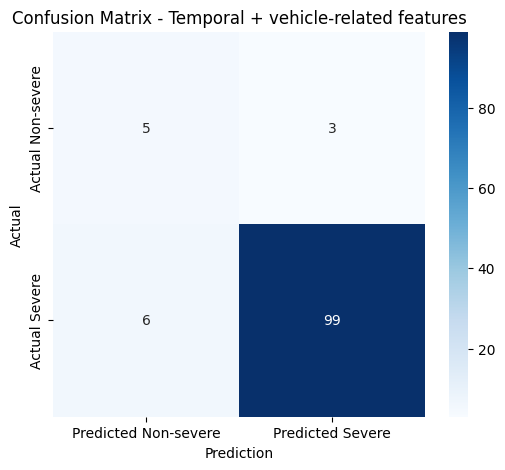

Classification Report for Temporal + vehicle-related features:

              precision    recall  f1-score   support

  Non-severe       0.45      0.62      0.53         8
      Severe       0.97      0.94      0.96       105

    accuracy                           0.92       113
   macro avg       0.71      0.78      0.74       113
weighted avg       0.93      0.92      0.93       113



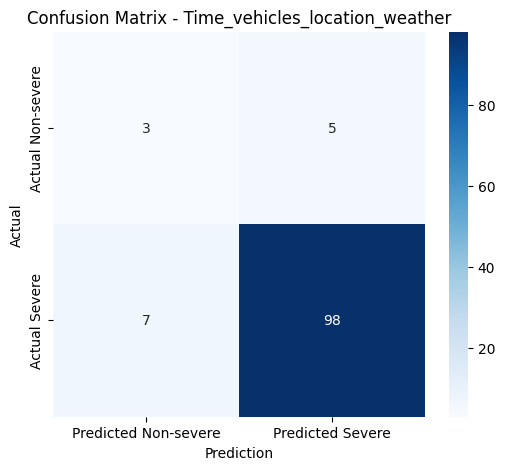

Classification Report for Time_vehicles_location_weather:

              precision    recall  f1-score   support

  Non-severe       0.30      0.38      0.33         8
      Severe       0.95      0.93      0.94       105

    accuracy                           0.89       113
   macro avg       0.63      0.65      0.64       113
weighted avg       0.91      0.89      0.90       113



In [50]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

results_df = pd.DataFrame(results).sort_values("f1", ascending=False)

def plot_confusion_matrix(y_true, y_pred, model_name):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    # Plot the confusion matrix using a heatmap
    sns.heatmap(
        cm,
        annot=True, # Annotate cells with the numeric values
        fmt="d",    # Format annotations as integers
        cmap="Blues", # Color map for the heatmap
        xticklabels=["Predicted Non-severe", "Predicted Severe"], # Labels for predicted classes
        yticklabels=["Actual Non-severe", "Actual Severe"]    # Labels for actual classes
    )
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    # Print the classification report for detailed metrics
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=["Non-severe", "Severe"]))

# Get results for 'Time_plus_vehicles' model
model_tpv = results_df[results_df['model'] == 'Time_plus_vehicles'].iloc[0]
y_test_tpv = model_tpv['y_test']
y_pred_tpv = model_tpv['y_pred']

# Plot the confusion matrix for 'Time_plus_vehicles' model
plot_confusion_matrix(y_test_tpv, y_pred_tpv, 'Temporal + vehicle-related features')

# Get results for 'Time_vehicles_location_weather' model
model_tvlw = results_df[results_df['model'] == 'Time_vehicles_location_weather'].iloc[0]
y_test_tvlw = model_tvlw['y_test']
y_pred_tvlw = model_tvlw['y_pred']

# Plot the confusion matrix for 'Time_vehicles_location_weather' model
plot_confusion_matrix(y_test_tvlw, y_pred_tvlw, 'Time_vehicles_location_weather')

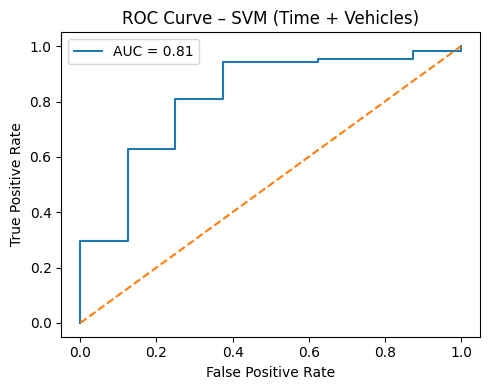

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# 1. Get the feature specification for 'Time_plus_vehicles' from FEATURE_SETS
spec = FEATURE_SETS['Time_plus_vehicles']
cat_cols = spec['cat']
num_cols = spec['num']

# 2. Prepare X_train, y_train, X_test, y_test for this specific model
# Select the relevant columns from the training and testing DataFrames
use_cols_tpv = cat_cols + num_cols + [TARGET_COL]

X_train_tpv = train_df[use_cols_tpv].drop(columns=[TARGET_COL]).copy()
y_train_tpv = train_df[TARGET_COL].copy()

X_test_tpv = test_df[use_cols_tpv].drop(columns=[TARGET_COL]).copy()
y_test_tpv = test_df[TARGET_COL].copy()

# 3. Re-create the preprocessing and model pipeline for 'Time_plus_vehicles'
preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
    ],
    remainder="drop"
)

# Create the SVM model pipeline, ensuring 'probability=True' for ROC curve calculation
svm_model_tpv = Pipeline([
    ("preprocess", preprocess),
    ("svm", SVC(kernel="rbf", class_weight="balanced", random_state=42, probability=True)) # probability=True is needed for predict_proba
])

# 4. Fit the model and get prediction probabilities (decision scores)
svm_model_tpv.fit(X_train_tpv, y_train_tpv)
y_scores = svm_model_tpv.predict_proba(X_test_tpv)[:, 1] # Get probabilities for the positive class

# 5. Plot ROC curve
# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr, tpr, _ = roc_curve(y_test_tpv, y_scores)
# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
# Plot the ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
# Plot the random guess line (AUC = 0.5)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM (Time + Vehicles)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a new figure and add a 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
# x-axis: Hour, y-axis: Vehicle count, z-axis: Traffic flag
# Points are colored by 'severe_flag' (severity of the accident)
ax.scatter(
    eda_df["hour"],
    eda_df["vehicle_count"],
    eda_df["traffic_flag"],
    c=eda_df["severe_flag"],
    alpha=0.6 # Set transparency for better visibility of overlapping points
)

# Set labels for the axes
ax.set_xlabel("Hour")
ax.set_ylabel("Vehicle count")
ax.set_zlabel("Traffic flag")
plt.show()

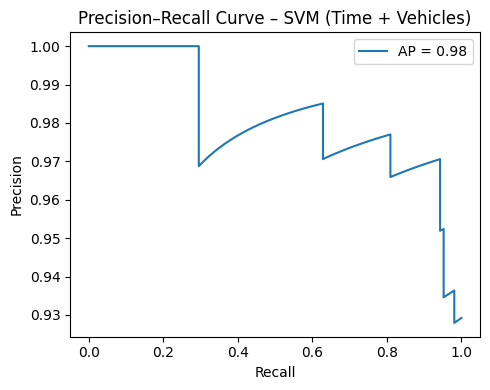

In [51]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall pairs for various probability thresholds
precision, recall, _ = precision_recall_curve(y_test_tpv, y_scores) # Using y_test_tpv and y_scores from the previous cell
# Calculate the Average Precision (AP) score
ap = average_precision_score(y_test_tpv, y_scores)

plt.figure(figsize=(5,4))
# Plot the Precision-Recall curve
plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – SVM (Time + Vehicles)")
plt.legend()
plt.tight_layout()
plt.show()

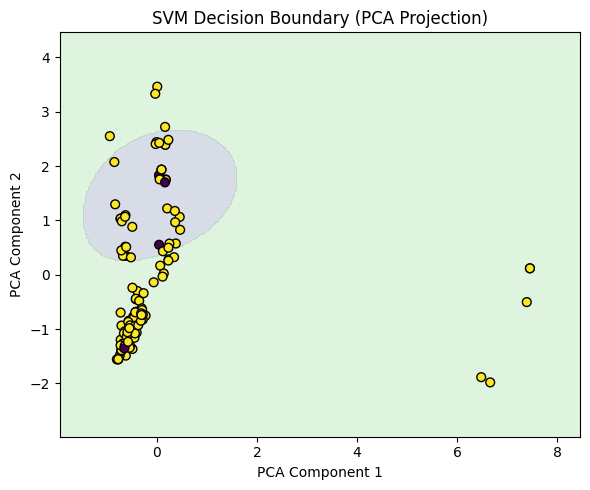

In [52]:
from sklearn.decomposition import PCA
import numpy as np

# Get preprocessed features for the test set from the fitted SVM pipeline
X_test_transformed = svm_model_tpv.named_steps["preprocess"].transform(X_test_tpv)

# Reduce the dimensionality of the preprocessed features to 2 components using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_transformed)

# Fit a simple SVM on the 2D PCA space (for visualization purposes only)
from sklearn.svm import SVC
svm_vis = SVC(kernel="rbf", class_weight="balanced")
svm_vis.fit(X_pca, y_test_tpv)

# Create a meshgrid to plot the decision boundary
xx, yy = np.meshgrid(
    np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 300),
    np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 300)
)

# Get the decision function values for each point in the meshgrid
Z = svm_vis.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting the PCA projection with SVM decision boundary
plt.figure(figsize=(6,5))
# Plot the decision boundary by contouring where Z is greater than 0
plt.contourf(xx, yy, Z > 0, alpha=0.2)
# Plot the data points, colored by their actual severity
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_test_tpv, edgecolor="k", s=40)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("SVM Decision Boundary (PCA Projection)")
plt.tight_layout()
plt.show()